In [1]:
import warnings
warnings.filterwarnings('ignore')
import h5py
from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pycbc.io.inference_hdf import InferenceFile
import numpy
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['font.size'] = 16

The data files store posteriors for the variable parameters ( `variable_args` ) in the MCMC. To check the parameter names that are stored in the posteriors file from the analysis of any of the events (say GW150914), use the appropriate file and do :

In [2]:
fp = h5py.File("./gw150914_posteriors_thinned.hdf", "r")
print fp.attrs['variable_args']
fp.close()

['tc' 'mass1' 'mass2' 'spin1_a' 'spin1_azimuthal' 'spin1_polar' 'spin2_a'
 'spin2_azimuthal' 'spin2_polar' 'distance' 'inclination' 'polarization'
 'ra' 'dec']


Posteriors for the `variable_args` are stored inside the `samples` group of the hdf data files. PyCBC provides a handler class `pycbc.io.InferenceFile` that extends `h5py.File`. To read the output file and get samples for any of the `variable_args`, say `mass1`, do :

In [3]:
fp = InferenceFile("./gw150914_posteriors_thinned.hdf", "r")
mass1_samples = fp['samples/mass1'][:]
print mass1_samples

[49.91336611 46.58329292 50.60107116 ... 37.60622535 37.59476261
 38.03140866]


Using the PyCBC software, one can map the posteriors for the `variable_args` to posteriors of other parameters. PyCBC has several functions that can be used to do the general transforms between parameters. You can look in `pycbc.conversions`, `pycbc.coordinates`, `pycbc.cosmology` for the possible transforms that you can do with the available `variable_args`. For example, to obtain the the chirp mass of the binary `mchirp` from the component masses `(mass1, mass2)` one would do :

In [4]:
from pycbc import conversions

fp=InferenceFile("./gw150914_posteriors_thinned.hdf",'r')
mass1 = fp['samples/mass1'][:]
mass2 = fp['samples/mass2'][:]
fp.close()

mchirp = conversions.mchirp_from_mass1_mass2(mass1, mass2)
print mchirp

[43.11708375 38.16646487 33.09684455 ... 31.91053001 31.90495054
 32.17238685]


PyCBC has some common transforms pre-defined in the code, which can be used to derive some of the standard parameters from the `variable_args` parameters in the data file. For example, `( mass1, mass2 )` present in `variable_args` can be used to obtain derived parameters such as `mchirp` and `q`. The parameters whose posteriors are plotted below include some of such derived parameters. 

Below are examples that will plot posteriors from the PyCBC Inference analysis of GW150914 presented in Figures 4, 5 and 6 in the paper. 

For generating the the $m_1^{\mathrm{src}} - m_2^{\mathrm{src}}$ posteriors plot, we have utilized plotting functions from the module https://github.com/gwastro/pycbc/blob/v1.12.3/pycbc/results/scatter_histograms.py in PyCBC. 
To generate the $q - \chi_{\mathrm{eff}}$ and $d_L - \iota$ posteriors plots, we use the built-in plotting executable `pycbc_inference_plot_posterior` provided by PyCBC Inference that handles formatting and any necessary parameter conversions. Some formatting differences may be present, but if you're running a development version of PyCBC then you can adjust these as desired in the plotting code.

### Some plotting functions used in generating $m_1 - m_2$ posteriors 

In [5]:
import argparse
import logging
import numpy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import pycbc
import pycbc.version
import sys
from matplotlib import patches
from matplotlib import pyplot
from pycbc.inference import option_utils, likelihood
from pycbc.io.inference_hdf import InferenceFile
from pycbc.results import metadata
from pycbc.results.scatter_histograms import create_multidim_plot
import numpy
import scipy.stats
import itertools
import matplotlib

from pycbc.results.scatter_histograms import construct_kde, create_axes_grid, get_scale_fac, create_marginalized_hist, set_marginal_histogram_title, remove_common_offset, reduce_ticks
# Only if a backend is not already set ... This should really *not* be done
# here, but in the executables you should set matplotlib.use()
# This matches the check that matplotlib does internally, but this *may* be
# version dependenant. If this is a problem then remove this and control from
# the executables directly.
#if not 'matplotlib.backends' in sys.modules:
#    matplotlib.use('agg')
from matplotlib import offsetbox
from matplotlib import pyplot
import matplotlib.gridspec as gridspec
from pycbc.results import str_utils
from pycbc.io import FieldArray
import matplotlib.ticker as ticker



def create_multidim_plot(parameters, samples, labels=None,
                mins=None, maxs=None, expected_parameters=None,
                expected_parameters_color='r',
                plot_marginal=True, plot_scatter=True,
                marginal_percentiles=None, contour_percentiles=None,
                zvals=None, show_colorbar=True, cbar_label=None,
                vmin=None, vmax=None, scatter_cmap='plasma',
                plot_density=False, plot_contours=True,
                density_cmap='viridis',
                contour_color=None, hist_color='black',
                line_color=None, fill_color='gray',
                use_kombine=False, fig=None, axis_dict=None, grid_on=False):
    """Generate a figure with several plots and histograms.

    Parameters
    ----------
    parameters: list
        Names of the variables to be plotted.
    samples : FieldArray
        A field array of the samples to plot.
    labels: {None, list}, optional
        A list of names for the parameters.
    mins : {None, dict}, optional
        Minimum value for the axis of each variable in `parameters`.
        If None, it will use the minimum of the corresponding variable in
        `samples`.
    maxs : {None, dict}, optional
        Maximum value for the axis of each variable in `parameters`.
        If None, it will use the maximum of the corresponding variable in
        `samples`.
    expected_parameters : {None, dict}, optional
        Expected values of `parameters`, as a dictionary mapping parameter
        names -> values. A cross will be plotted at the location of the
        expected parameters on axes that plot any of the expected parameters.
    expected_parameters_color : {'r', string}, optional
        What color to make the expected parameters cross.
    plot_marginal : {True, bool}
        Plot the marginalized distribution on the diagonals. If False, the
        diagonal axes will be turned off.
    plot_scatter : {True, bool}
        Plot each sample point as a scatter plot.
    marginal_percentiles : {None, array}
        What percentiles to draw lines at on the 1D histograms.
        If None, will draw lines at `[5, 50, 95]` (i.e., the bounds on the
        upper 90th percentile and the median).
    contour_percentiles : {None, array}
        What percentile contours to draw on the scatter plots. If None,
        will plot the 50th and 90th percentiles.
    zvals : {None, array}
        An array to use for coloring the scatter plots. If None, scatter points
        will be the same color.
    show_colorbar : {True, bool}
        Show the colorbar of zvalues used for the scatter points. A ValueError
        will be raised if zvals is None and this is True.
    cbar_label : {None, str}
        Specify a label to add to the colorbar.
    vmin: {None, float}, optional
        Minimum value for the colorbar. If None, will use the minimum of zvals.
    vmax: {None, float}, optional
        Maximum value for the colorbar. If None, will use the maxmimum of
        zvals.
    scatter_cmap : {'plasma', string}
        The color map to use for the scatter points. Default is 'plasma'.
    plot_density : {False, bool}
        Plot the density of points as a color map.
    plot_contours : {True, bool}
        Draw contours showing the 50th and 90th percentile confidence regions.
    density_cmap : {'viridis', string}
        The color map to use for the density plot.
    contour_color : {None, string}
        The color to use for the contour lines. Defaults to white for
        density plots, navy for scatter plots without zvals, and black
        otherwise.
    use_kombine : {False, bool}
        Use kombine's KDE to calculate density. Otherwise, will use
        `scipy.stats.gaussian_kde.` Default is False.

    Returns
    -------
    fig : pyplot.figure
        The figure that was created.
    axis_dict : dict
        A dictionary mapping the parameter combinations to the axis and their
        location in the subplots grid; i.e., the key, values are:
        `{('param1', 'param2'): (pyplot.axes, row index, column index)}`
    """
    if labels is None:
        labels = [p for p in parameters]
    # turn labels into a dict for easier access
    labels = dict(zip(parameters, labels))
    # set up the figure with a grid of axes
    # if only plotting 2 parameters, make the marginal plots smaller
    nparams = len(parameters)
    if nparams == 2:
        width_ratios = [3,1]
        height_ratios = [1,3]
    else:
        width_ratios = height_ratios = None


    # convert samples to a dictionary to avoid re-computing derived parameters
    # every time they are needed
    samples = dict([[p, samples[p]] for p in parameters])

    # values for axis bounds
    if mins is None:
        mins = {p:samples[p].min() for p in parameters}
    else:
        # copy the dict
        mins = {p:val for p,val in mins.items()}
    if maxs is None:
        maxs = {p:samples[p].max() for p in parameters}
    else:
        # copy the dict
        maxs = {p:val for p,val in maxs.items()}

    # remove common offsets
    for pi,param in enumerate(parameters):
        values, offset = remove_common_offset(samples[param])
        if offset != 0:
            # we'll add the offset removed to the label
            labels[param] = '{} - {:d}'.format(labels[param], offset)
            samples[param] = values
            mins[param] = mins[param] - float(offset)
            maxs[param] = maxs[param] - float(offset)

    # create the axis grid
    if fig is None and axis_dict is None:
        fig, axis_dict = create_axes_grid(
            parameters, labels=labels,
            width_ratios=width_ratios, height_ratios=height_ratios,
            no_diagonals=not plot_marginal)
        
    # Diagonals...
    if plot_marginal:
        for pi,param in enumerate(parameters):
            ax, _, _ = axis_dict[param, param]
            # if only plotting 2 parameters and on the second parameter,
            # rotate the marginal plot
            rotated = nparams == 2 and pi == nparams-1
            # see if there are expected values
            if expected_parameters is not None:
                try:
                    expected_value = expected_parameters[param]
                except KeyError:
                    expected_value = None
            else:
                expected_value = None
            create_marginalized_hist(ax, samples[param], label=labels[param],
                color=hist_color, fillcolor=fill_color, linecolor=line_color,
                title=True, expected_value=expected_value,
                expected_color=expected_parameters_color,
                rotated=rotated, plot_min=mins[param], plot_max=maxs[param],
                percentiles=marginal_percentiles)

    # Off-diagonals...
    for px, py in axis_dict:
        if px == py:
            continue
        ax, _, _ = axis_dict[px, py]

        if plot_contours or plot_density:
            # Exclude out-of-bound regions
            # this is a bit kludgy; should probably figure out a better
            # solution to eventually allow for more than just m_p m_s
            if (px == 'm_p' and py == 'm_s') or (py == 'm_p' and px == 'm_s'):
                exclude_region = 'm_s > m_p'
            else:
                exclude_region = None
            create_density_plot(px, py, samples, plot_density=plot_density,
                    plot_contours=plot_contours, cmap=density_cmap,
                    percentiles=contour_percentiles,
                    contour_color=contour_color, xmin=mins[px], xmax=maxs[px],
                    ymin=mins[py], ymax=maxs[py],
                    exclude_region=exclude_region, ax=ax,
                    use_kombine=use_kombine, grid_on=grid_on)

        ax.set_xlim(mins[px], maxs[px])
        ax.set_ylim(mins[py], maxs[py])

    # adjust tick number for large number of plots
    if len(parameters) > 3:
        for px, py in axis_dict:
            ax, _, _ = axis_dict[px, py]
            ax.set_xticks(reduce_ticks(ax, 'x', maxticks=3))
            ax.set_yticks(reduce_ticks(ax, 'y', maxticks=3))

    return fig, axis_dict



## To plot Fig. 4 of the paper : GW150914 posteriors

### Fig 4a : posterior density plot for $m_1^{\mathrm{src}} - m_2^{\mathrm{src}}$

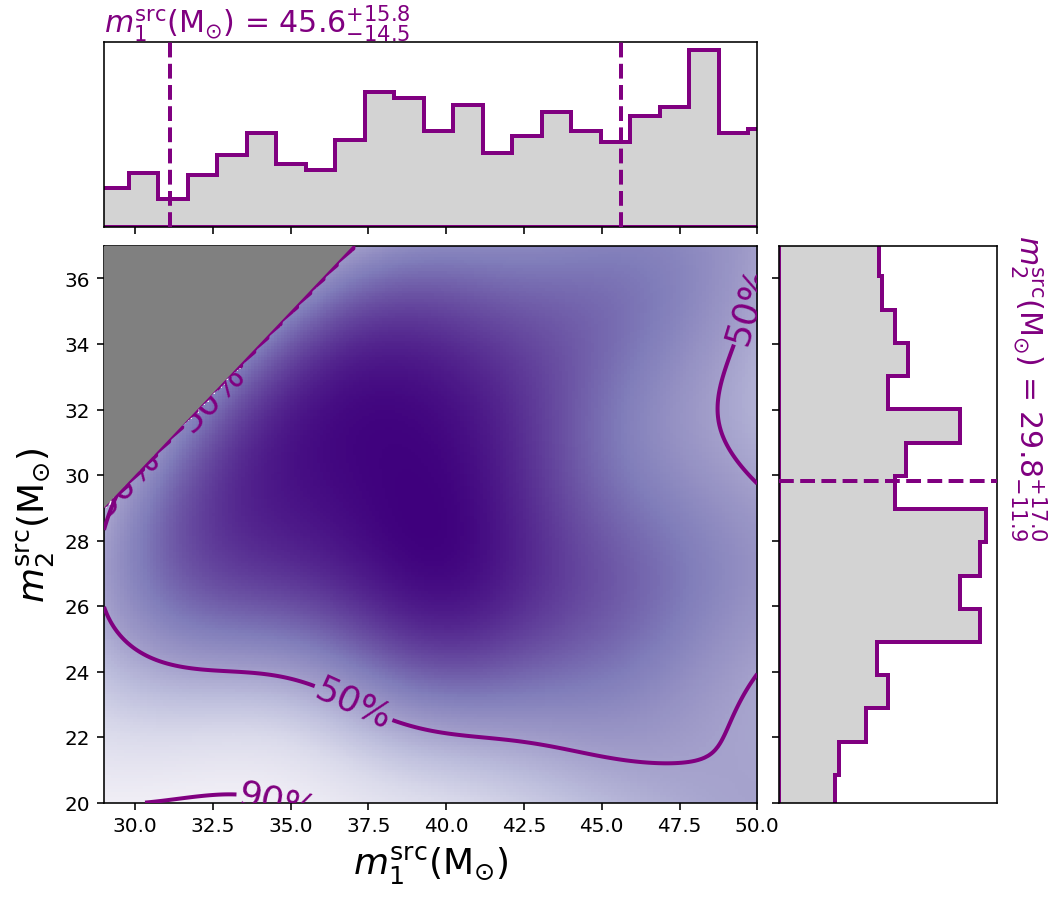

In [6]:
def create_density_plot(xparam, yparam, samples, plot_density=True,
        plot_contours=True, percentiles=None, cmap='viridis',
        contour_color=None, xmin=None, xmax=None, ymin=None, ymax=None,
        exclude_region=None, fig=None, ax=None, use_kombine=False, grid_on=False):
    """Computes and plots posterior density and confidence intervals using the
    given samples.

    Parameters
    ----------
    xparam : string
        The parameter to plot on the x-axis.
    yparam : string
        The parameter to plot on the y-axis.
    samples : dict, numpy structured array, or FieldArray
        The samples to plot.
    plot_density : {True, bool}
        Plot a color map of the density.
    plot_contours : {True, bool}
        Plot contours showing the n-th percentiles of the density.
    percentiles : {None, float or array}
        What percentile contours to draw. If None, will plot the 50th
        and 90th percentiles.
    cmap : {'viridis', string}
        The name of the colormap to use for the density plot.
    contour_color : {None, string}
        What color to make the contours. Default is white for density
        plots and black for other plots.
    xmin : {None, float}
        Minimum value to plot on x-axis.
    xmax : {None, float}
        Maximum value to plot on x-axis.
    ymin : {None, float}
        Minimum value to plot on y-axis.
    ymax : {None, float}
        Maximum value to plot on y-axis.
    exclue_region : {None, str}
        Exclude the specified region when plotting the density or contours.
        Must be a string in terms of `xparam` and `yparam` that is
        understandable by numpy's logical evaluation. For example, if
        `xparam = m_1` and `yparam = m_2`, and you want to exclude the region
        for which `m_2` is greater than `m_1`, then exclude region should be
        `'m_2 > m_1'`.
    fig : {None, pyplot.figure}
        Add the plot to the given figure. If None and ax is None, will create
        a new figure.
    ax : {None, pyplot.axes}
        Draw plot on the given axis. If None, will create a new axis from
        `fig`.
    use_kombine : {False, bool}
        Use kombine's KDE to calculate density. Otherwise, will use
        `scipy.stats.gaussian_kde.` Default is False.

    Returns
    -------
    fig : pyplot.figure
        The figure the plot was made on.
    ax : pyplot.axes
        The axes the plot was drawn on.
    """
    if percentiles is None:
        percentiles = numpy.array([50., 90.])
    percentiles = 100. - numpy.array(percentiles)
    percentiles.sort()
    if ax is None and fig is None:
        fig = pyplot.figure()
    if ax is None:
        ax = fig.add_subplot(111)

    if grid_on:
        ax.grid(True, linestyle='dotted', color='darkgray')
    # convert samples to array and construct kde
    xsamples = samples[xparam]
    ysamples = samples[yparam]
    arr = numpy.vstack((xsamples, ysamples)).T
    kde = construct_kde(arr, use_kombine=use_kombine)

    # construct grid to evaluate on
    if xmin is None:
        xmin = xsamples.min()
    if xmax is None:
        xmax = xsamples.max()
    if ymin is None:
        ymin = ysamples.min()
    if ymax is None:
        ymax = ysamples.max()
    npts = 200
    X, Y = numpy.mgrid[xmin:xmax:complex(0,npts), ymin:ymax:complex(0,npts)] # pylint:disable=invalid-slice-index
    X_ravel = X.ravel()
    Y_ravel = Y.ravel()
    pos = numpy.vstack([X_ravel, Y_ravel])

    Z_ravel = kde(pos).T
    draw = kde.resample


    for i in range(len(X_ravel)):
        if X_ravel[i] <= Y_ravel[i]:
            Z_ravel[i] = 0
    X = X_ravel.reshape(X.shape)
    Y = Y_ravel.reshape(X.shape)
    Z = Z_ravel.reshape(X.shape)
    
    if plot_density:
        ax.imshow(numpy.rot90(Z), extent=[xmin, xmax, ymin, ymax],
            aspect='auto', cmap=cmap, zorder=1)
        if contour_color is None:
            contour_color = 'w'
            
    if plot_contours:
        # compute the percentile values
        resamps = kde(draw(int(npts**2)))
        if use_kombine:
            resamps = numpy.exp(resamps)
        s = numpy.percentile(resamps, percentiles)
        if contour_color is None:
            contour_color = 'k'
        lw = 2
        ct = ax.contour(X, Y, Z, s, colors=contour_color, linewidths=lw, linestyles='solid',
                        zorder=3)
        
        # label contours
        lbls = ['{p}%'.format(p=int(p)) for p in (100. - percentiles)]
        
        fmt = dict(zip(ct.levels, lbls))
        fs = 18
        ax.clabel(ct, ct.levels, inline=True, fmt=fmt, fontsize=fs)
        
        x=numpy.linspace(29, 50, num=50)
        y1=x
        ax.fill_between(x, x, 37, facecolor='gray', zorder=10)

    return fig, ax


sys.argv = ['foo']
parser = argparse.ArgumentParser()

opts = parser.parse_args()
opts.output_file = 'm1m2source_gw150914.png'
opts.input_file = ['./gw150914_posteriors_thinned.hdf']
opts.plot_marginal = True
opts.plot_contour = True
opts.plot_density = True
opts.z_arg = "logplr"
opts.density_cmap = "Purples"
opts.parameters = ['primary_mass(mass1, mass2)/(1+redshift):$m_1^{\\mathrm{src}}    (\\mathrm{M}_{\\odot})$', 'secondary_mass(mass1, mass2)/(1+redshift):$m_2^{\\mathrm{src}}    (\\mathrm{M}_{\\odot})$']
opts.maxs=['primary_mass(mass1, mass2)/(1+redshift):50', 'secondary_mass(mass1, mass2)/(1+redshift):37']
opts.mins=['primary_mass(mass1, mass2)/(1+redshift):29', 'secondary_mass(mass1, mass2)/(1+redshift):20']
opts.thin_start = None
opts.thin_interval=None
opts.thin_end = None
opts.iteration =None
opts.parameters_group='samples'
opts.marginal_percentiles=None

# add options for what plots to create
option_utils.add_plot_posterior_option_group(parser)

# density configuration
option_utils.add_density_option_group(parser)

# add standard option utils
option_utils.add_inference_results_option_group(parser)

# get parameters
fp, parameters, labels, samples = option_utils.results_from_cli(opts)

mins, maxs = option_utils.plot_ranges_from_cli(opts)


fig = None
axis_dict = None
fill_color = "lightgray"
zvals = []
zlbl = []

likelihood_stats = fp.read_likelihood_stats(
                        thin_start=opts.thin_start, thin_end=opts.thin_end,
                        thin_interval=opts.thin_interval, iteration=opts.iteration)
f_zvals, f_zlbl = option_utils.get_zvalues(fp, opts.z_arg, likelihood_stats)

zvals.append(f_zvals)
zlbl.append(f_zlbl)
fp.close()

contour_color = "purple"

# make histogram black lines if only one
hist_color = contour_color
# pick a new color for each input file
linecolor = contour_color

# plot
fig, axis_dict = create_multidim_plot(
                    parameters, samples, labels=labels, fig=fig, axis_dict=axis_dict,
                    marginal_percentiles=opts.marginal_percentiles,
                    zvals=zvals if zvals is not None else None,
                    plot_density=opts.plot_density,
                    plot_contours=opts.plot_contour,
                    density_cmap=opts.density_cmap,
                    contour_color=contour_color,
                    hist_color=hist_color,
                    line_color=contour_color,
                    fill_color=fill_color,
                    mins=mins, maxs=maxs)
    
    
fig.show()

### Fig 4b : posterior density plot for $q - \chi_{\mathrm{eff}}$

In [9]:
!sh plot.sh

/anaconda3/envs/pycbc_v1_12_3/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2019-08-20 21:33:30,342 Loading parameters
2019-08-20 21:33:30,342 Reading input file ./gw150914_posteriors_thinned.hdf
2019-08-20 21:33:30,346 Loading samples
2019-08-20 21:33:30,513 Getting likelihood stats
2019-08-20 21:33:30,522 Plotting
/anaconda3/envs/pycbc_v1_12_3/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/pycbc_v1_12_3/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be 

2019-08-20 21:33:34,360 STREAM 'IHDR' 16 13
2019-08-20 21:33:34,360 STREAM 'sBIT' 41 4
2019-08-20 21:33:34,360 'sBIT' 41 4 (unknown)
2019-08-20 21:33:34,360 STREAM 'pHYs' 57 9
2019-08-20 21:33:34,361 STREAM 'tEXt' 78 57
2019-08-20 21:33:34,361 STREAM 'IDAT' 147 8192
2019-08-20 21:33:34,855 Done
/anaconda3/envs/pycbc_v1_12_3/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2019-08-20 21:33:40,253 Loading parameters
2019-08-20 21:33:40,253 Reading input file ./gw150914_posteriors_thinned.hdf
2019-08-20 21:33:40,256 Loading samples
2019-08-20 21:33:40,266 Getting likelihood stats
2019-08-20 21:33:40,271 Plotting
/anaconda3/envs/pycbc_v1_12_3/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and

2019-08-20 21:33:42,799 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans (u'/anaconda3/envs/python27/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2019-08-20 21:33:42,961 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans (u'/anaconda3/envs/python27/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2019-08-20 21:33:43,837 STREAM 'IHDR' 16 13
2019-08-20 21:33:43,838 STREAM 'sBIT' 41 4
2019-08-20 21:33:43,841 'sBIT' 41 4 (unknown)
2019-08-20 21:33:43,841 STREAM 'pHYs' 57 9
2019-08-20 21:33:43,841 STREAM 'tEXt' 78 57
2019-08-20 21:33:43,842 STREAM 'IDAT' 147 8192
2019-08-20 21:33:44,497 Done


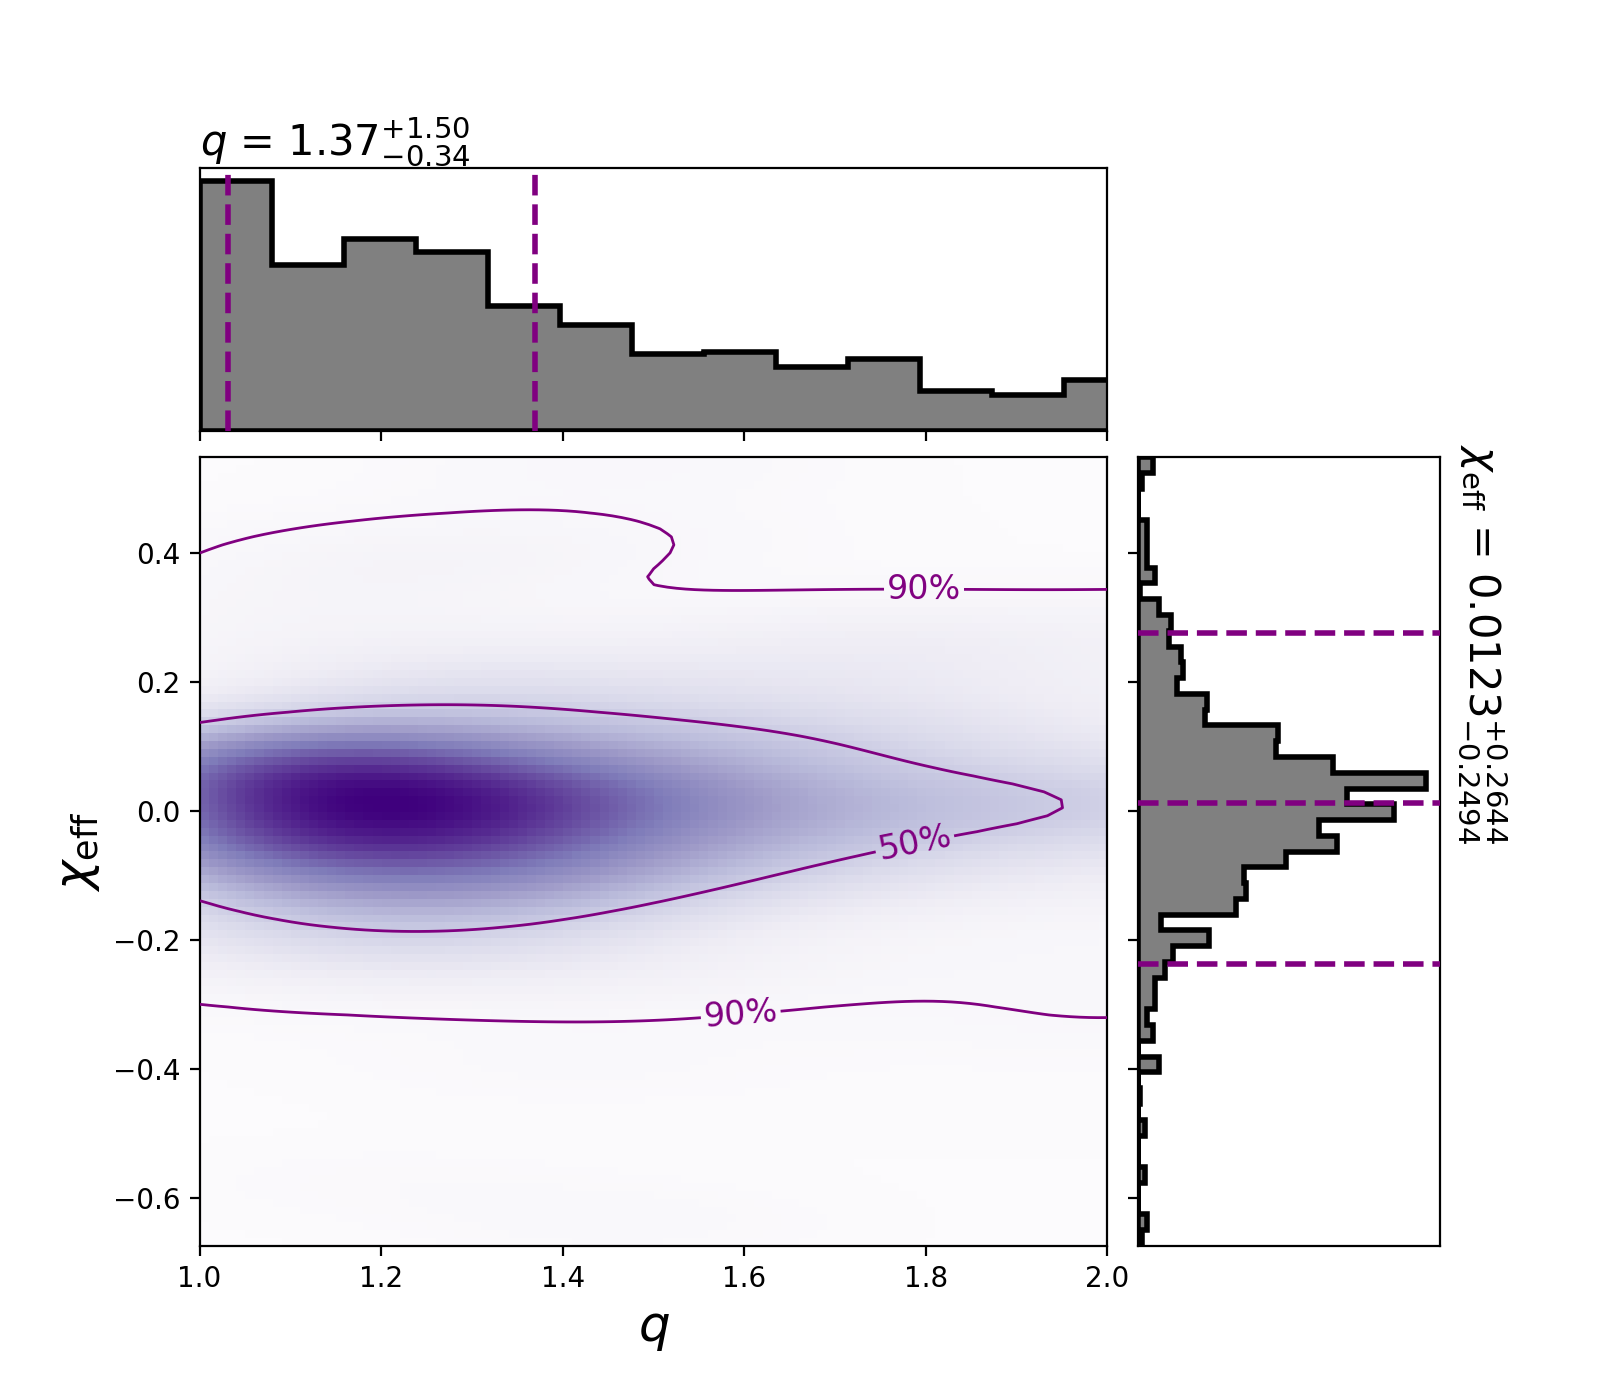

In [10]:
Image('q_chieff_gw150914.png')

### Fig 4c : posterior density plot for $\iota - d_L$

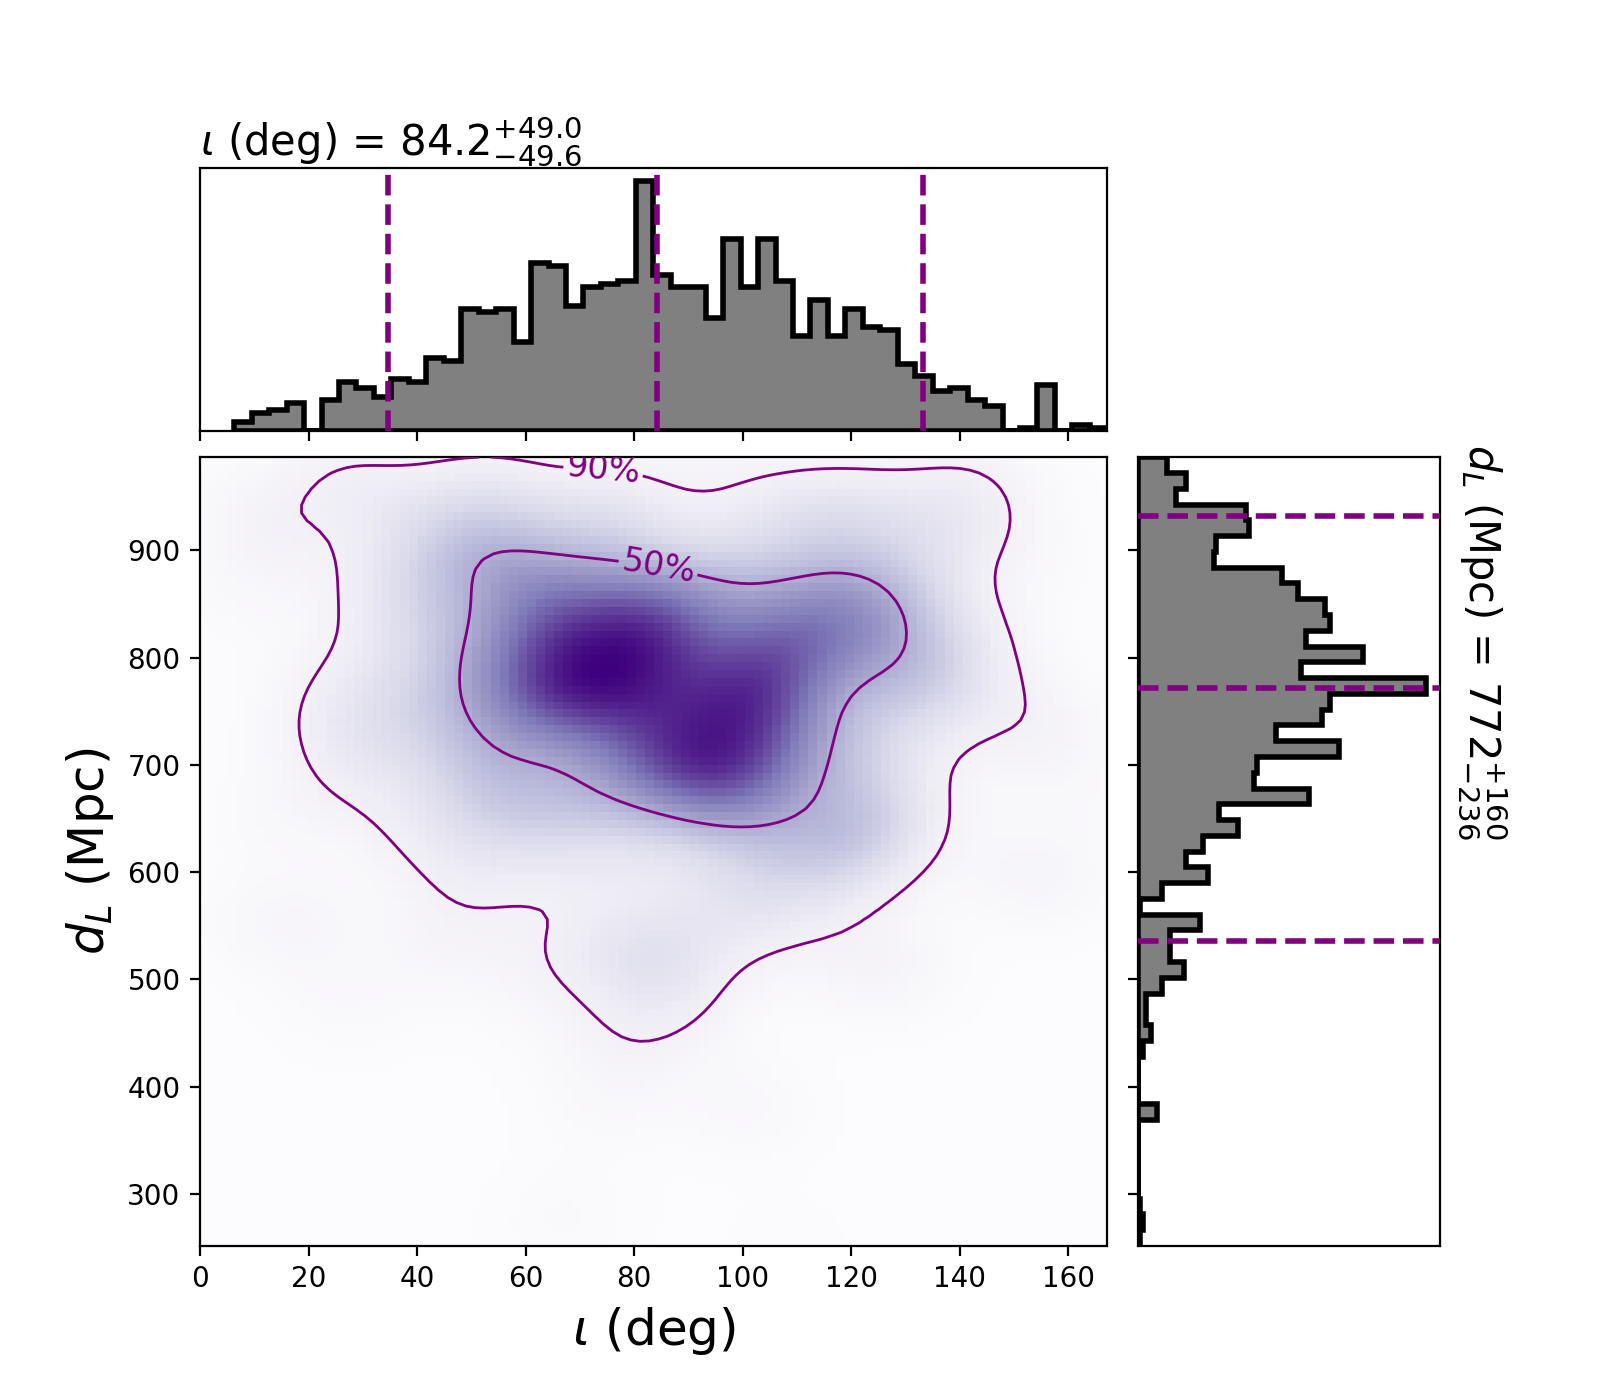

In [11]:
Image('iota_dl_gw150914.png')